<a href="https://colab.research.google.com/github/NotAndex/Demo/blob/main/Supervised_anomaly_detection_comparison_of_models_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_recall_curve
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

#Models
import tensorflow as tf
from xgboost import XGBClassifier

#
!pip install keras-tuner
import keras_tuner as kt

import IPython.display
IPython.display.clear_output()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (16, 9)

# Pre-Processing

In [2]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

df.rename(columns={'Class':'label'}, inplace=True)
df['log10_amount'] = np.log10(df.Amount + 0.00001)
df = df.drop(['Time','Amount'],axis=1)

X = df.drop('label', axis=1)
y = df.label

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)
    
X_train, X_validate, y_train, y_validate = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=42)
   
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

pipeline.fit(X_train)

X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)
X_test_transformed = pipeline.transform(X_test)
      
fraud_weight = len(y_train[y_train == 1]) / len(y_train)
no_fraud_weight = len(y_train[y_train == 0]) / len(y_train)

# Convenience Functions


In [3]:
def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n")

def plot_metrics(history):
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  metrics = ['loss', 'aucpr', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()

def aucpr(labels, predictions):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
    return(sklearn.metrics.auc(recall, precision))

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
    
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

# Models

## ANN

### Hyperparameter Tuning

This section shows an exemplary implementation of Hyperparameter Tuning with keras_tuner. The parameters below are deterministic because only the output of the tuner should be emphasized.  

In [4]:
def model_builder(hp):
    model = tf.keras.Sequential()
  
    first_l_units = hp.Int('first_l_units', min_value=256, max_value=256, step = 128)
    second_l_units = hp.Int('second_l_units', min_value=256, max_value=256, step = 128)
    third_l_units = hp.Int('third_l_units', min_value=256, max_value=256, step = 128)

    model.add(tf.keras.layers.Dense(first_l_units, activation='relu', input_shape=(X_train.shape[-1],)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Dense(second_l_units, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(third_l_units, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='aucpr', curve='PR'), # precision-recall curve
    ]
    
    
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy', metrics=METRICS)
    
    return model




tuner = kt.RandomSearch(model_builder,
                     objective= kt.Objective('val_aucpr', direction="max"),
                     max_trials = 10,
                     directory='my_dir',
                     project_name='intro_to_kt'
                     )

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_aucpr',
    patience=10,
    verbose=1, 
    mode='max',
    restore_best_weights=True
)      

tuner.search(X_train, y_train,
             validation_data=(X_validate, y_validate),
             batch_size=2048, 
             epochs=100,
             callbacks=[early_stop])

Trial 1 Complete [00h 01m 09s]
val_aucpr: 0.8037558794021606

Best val_aucpr So Far: 0.8037558794021606
Total elapsed time: 00h 01m 09s
INFO:tensorflow:Oracle triggered exit


Here you can see the output (the best hyperparameters) of the Hyperparameter tuning. Because we didn’t allow a range of parameters, the output is deterministic. -> model equals the nn_model defined below. 

In [7]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7680      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6

In [ ]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='aucpr', curve='PR'), # precision-recall curve
]

nn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='binary_crossentropy', metrics=METRICS)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_aucpr',
    patience=10,
    verbose=1, 
    mode='max',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='Neural_net_best_weights.hdf5',
    save_best_only=True,
    monitor='val_aucpr',
    verbose=0,
    mode='max'
)

cb = [early_stop,save_model]

nn_model_history = nn_model.fit(
    X_train, y_train, 
    validation_data=(X_validate, y_validate),
    batch_size=2048, 
    epochs=100, 
#   class_weight=class_weight,
    callbacks=cb
)

IPython.display.clear_output()

2671/2671 [==============================] - 13s 5ms/step - loss: 0.0026 - accuracy: 0.9995 - fn: 26.0000 - fp: 13.0000 - tn: 85294.0000 - tp: 110.0000 - precision: 0.8943 - recall: 0.8088 - auc: 0.9446 - aucpr: 0.8398
[0.0026135847438126802, 0.9995435476303101, 26.0, 13.0, 85294.0, 110.0, 0.8943089246749878, 0.8088235259056091, 0.9445974230766296, 0.8397992849349976]


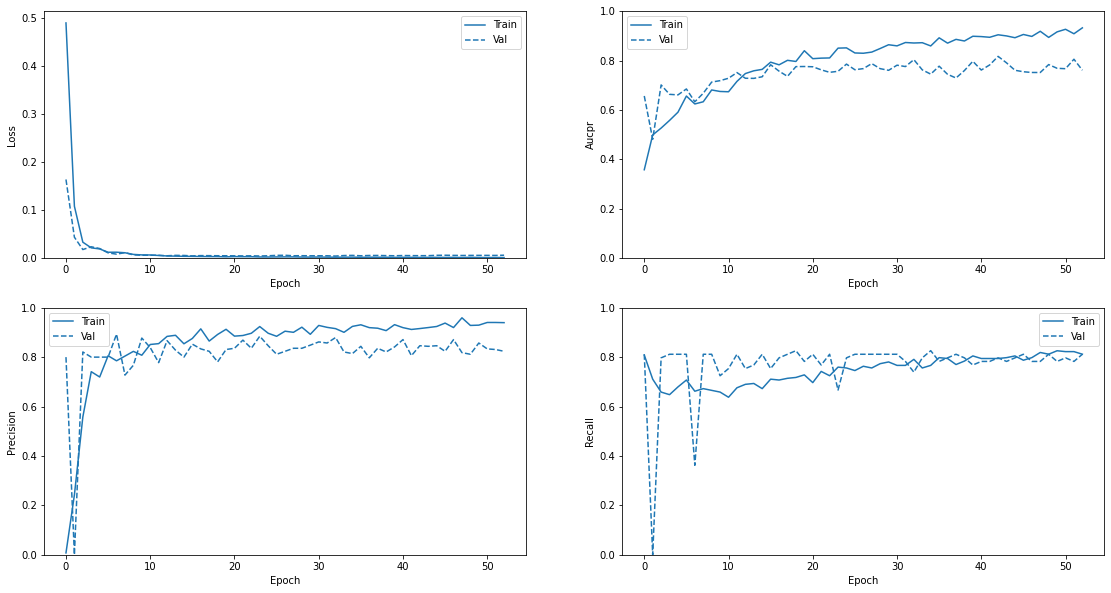

In [ ]:
nn_model_score = nn_model.evaluate(X_test, y_test)
plot_metrics(nn_model_history)
print(nn_model_score)

In [ ]:
y_train_pred_nn = nn_model.predict(X_train)
y_test_pred_nn = nn_model.predict(X_test)

print_score(y_train, y_train_pred_nn.round(), train=True)
print_score(y_test, y_test_pred_nn.round(), train=False)

scores = pd.DataFrame()
scores['NN'] = aucpr(y_train, y_train_pred_nn), aucpr(y_test, y_test_pred_nn)
scores = scores.rename(index={0:'train',1:'test'})

Train Result:
Accuracy Score: 99.97%
_______________________________________________
Classification Report:
                       0           1  accuracy      macro avg   weighted avg
precision       0.999743    0.987952  0.999724       0.993847       0.999721
recall          0.999981    0.857143  0.999724       0.928562       0.999724
f1-score        0.999862    0.917910  0.999724       0.958886       0.999714
support    159204.000000  287.000000  0.999724  159491.000000  159491.000000
_______________________________________________
Confusion Matrix: 
 [[159201      3]
 [    41    246]]

Test Result:
Accuracy Score: 99.95%
_______________________________________________
Classification Report:
                      0           1  accuracy     macro avg  weighted avg
precision      0.999695    0.894309  0.999544      0.947002      0.999528
recall         0.999848    0.808824  0.999544      0.904336      0.999544
f1-score       0.999771    0.849421  0.999544      0.924596      0.999532


## XGBoost

In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train,
            eval_set=[(X_validate, y_validate)],
            eval_metric=['aucpr'], verbose=True)

IPython.display.clear_output()

In [ ]:
y_train_pred_xgb = xgb_clf.predict(X_train)
y_test_pred_xgb = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred_xgb, train=True)
print_score(y_test, y_test_pred_xgb, train=False)
scores['XGB'] = aucpr(y_train, y_train_pred_xgb), aucpr(y_test, y_test_pred_xgb)

Train Result:
Accuracy Score: 99.97%
_______________________________________________
Classification Report:
                       0           1  accuracy      macro avg   weighted avg
precision       0.999705    0.979592  0.999674       0.989648       0.999669
recall          0.999969    0.836237  0.999674       0.918103       0.999674
f1-score        0.999837    0.902256  0.999674       0.951046       0.999661
support    159204.000000  287.000000  0.999674  159491.000000  159491.000000
_______________________________________________
Confusion Matrix: 
 [[159199      5]
 [    47    240]]

Test Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                      0           1  accuracy     macro avg  weighted avg
precision      0.999730    0.941667  0.999649      0.970699      0.999638
recall         0.999918    0.830882  0.999649      0.915400      0.999649
f1-score       0.999824    0.882813  0.999649      0.941318      0.999638


## CatBoost (TBI...)

## LightGBM (TBI...)

# Model Comparison

In [ ]:
scores

,NN,XGB
train,0.967366,0.908062
test,0.851560,0.886409


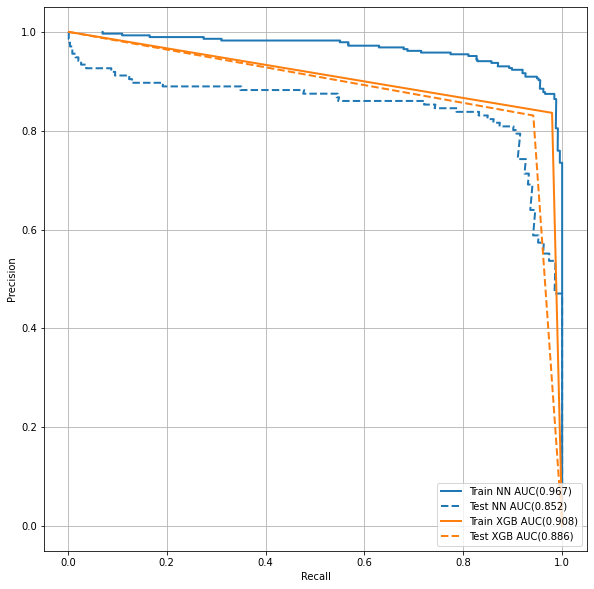

In [ ]:
plot_prc(f"Train NN AUC({scores.loc['train','NN']:.3})", y_train, y_train_pred_nn, color=colors[0])
plot_prc(f"Test NN AUC({scores.loc['test','NN']:.3})", y_test, y_test_pred_nn, color=colors[0], linestyle='--')
plot_prc(f"Train XGB AUC({scores.loc['train','XGB']:.3})", y_train, y_train_pred_xgb, color=colors[1])
plot_prc(f"Test XGB AUC({scores.loc['test','XGB']:.3})", y_test, y_test_pred_xgb, color=colors[1], linestyle='--')
plt.legend(loc='lower right')